In [1]:
%matplotlib inline

import pennylane as qml
from pennylane import numpy as np

Deutsch-Jozsa 
==============

*Author: Bruna Shinohara de Mendonça. Last updated: 18 Apr 2022.*

This might not be you first rodeo with the concept of Oracle [1], but here we will find it in a different context.

Consider that we have a function that, given an input (the qubits in the register), it may return:

I - All measurements in state $\vert 0 \rangle$ or in state $\vert 1 \rangle$;

II - Half of the measurements are in state $\vert 0 \rangle$ and half in state $\vert 1 \rangle$.

Function I is said to be **constant** and function II is said to be **balanced**.

Going back to classical computation: how could we differentiate these functions?
In that situation, we may need to check half of the inputs and one more: this would be the "worst case" scenario, i.e., the situation where all the states in the first half are either zero or one, so we would need to check one more state to make sure it is (or isn't constant). In other words, for a number $n$ of inputs, the worst case scenario requires

$$\text{Shots}_{\text{Classical}} = n/2 +1$$

Let's get quantum?
==============

The neat thing about Deutsch-Jozsa algorithm is that calling the function only one time is enough to tell its type!
We don't even have a "worst" case, since we always have

$$\text{Shots}_{\text{Quantum}} = 1$$

How?
===========================================

Here is the algorithm for a generic number of input qubits.
We need two registers: one will store the $n$ qubits that will be used as input, initialized in $\vert 0 \rangle$. 
The other will store a $\vert 1 \rangle$ state, that will work as an auxiliary qubit.

Thus, our first step is:

<ol>
   <li>
        Prepare two quantum registers as instructed above:
        

$$
\vert \psi_0 \rangle = \vert0\rangle^{\otimes n} \vert 1\rangle$$


   </li>
    
   <li>
        Apply Hadamard gates to all qubits, including the auxiliary one. We may write the obtained state as:
        

$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right)$$

Note the appearance of a misterious $\vert x \rangle$ state. This generic way of writing it is intentional, since this state is only necessary for the implementation of the oracle, but it does not intefere in the final state.
       
   </li>
   
   <li>
        Apply the quantum oracle. Here, it will act as $\vert x\rangle \vert y\rangle$ to $\vert x\rangle \vert y \oplus f(x)\rangle$,  $\oplus$ being the operation of addition modulo 2 [2]:
        $$
            \begin{aligned}
            \lvert \psi_2 \rangle  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) \\  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle ( |0\rangle - |1\rangle ) 
        \end{aligned}
        $$
       
   </li>

   <li>
       We now apply Hadamard gates to all qubit in the first register:
        $$
        \begin{aligned}
            \lvert \psi_3 \rangle 
                & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                    \left[ \sum_{y=0}^{2^n-1}(-1)^{x \cdot y} 
                    \vert y \rangle \right] \\
                & = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y} \right]
                    \vert y \rangle
        \end{aligned}
        $$
       
where $x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \ldots \oplus x_{n-1}y_{n-1}$.
       
The $\vert x\rangle$ state is already omitted from the equations, as it does not interfere at all after this point.
   </li>

   <li>
       Measure the first register.
   </li>
We will have two possible outputs when evaluating the probability of the final state to be in $\vert 0 \rangle ^{\otimes n}$. 
This is given by 

$$P(\vert 0 \rangle ^{\otimes n}) = \lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y} \langle 0^{\otimes n}\vert y \rangle \rvert^2$$
    
Note that $\langle 0^{\otimes n}\vert y \rangle = 1$ if $\vert y \rangle = \vert 0^{\otimes n}\rangle$ (and zero otherwise). 
When $\langle 0^{\otimes n}\vert y \rangle = 1$, $(-1)^{f(x)}(-1)^{x \cdot y} = (-1)^{f(x)}$
    
Therefore, our probability reduces to     
$$P(\vert 0 \rangle ^{\otimes n}) = \lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}\rvert^2$$
    
Now, if our f(x) is balanced, the equal number of zeros and ones will cancel the terms in the summation. Something like:
    
$$P(\vert 0 \rangle ^{\otimes n}) = \lvert \frac{1}{2^n}(-1)^{0}+(-1)^{1}+(-1)^{0}+(-1)^{1}+...\rvert^2 = 0$$

However, if our f(x) is constant, the sum would lead to:
    
$$P(\vert 0 \rangle ^{\otimes n}) = \lvert \frac{1}{2^n}(-1)^{f(x)}2^n\rvert^2 = 1$$
    
since $\lvert(-1)^{0}\lvert^2 = \lvert(-1)^{1}\lvert^2 = 1$.
    
Here is a sketch of the circuit:
</ol>


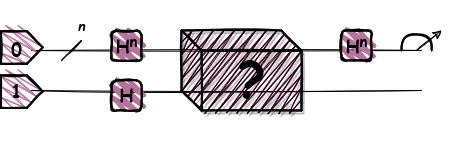

## Example: two-qubit register

How about we implement Deutsch-Jozsa algorithm in Pennylane?
Let us start simple, $n = 2$.

### I: Create initial states of the registers

In this case, we initialize by creating $\vert 0,0\rangle \otimes \vert 1 \rangle$.

In [2]:
dev = qml.device("default.qubit", wires=3, shots=1)

note that we use `wires = 3`, since we need on more qubit to use as auxiliary.

### II: Add Hadamard gates

In [3]:
bits = []
@qml.qnode(dev)
def circuit(bits):
    for qubit in range(len(bits) + 1):
        qml.Hadamard(qubit)
    qml.PauliX(wires=2)

Here, we also use a X gate to obtain a $\vert - \rangle$ state, as seen in the original algorithm.

### III: Call the oracle

The oracle function may be constructed in different ways, depending on whether you are aiming for a balanced or constant function. Here, we use an oracle that can be both, depending on the parameter `"bits"`.

This oracle is inspired by this QHack 2022 problem [3] - feel free to try it out!

In [4]:
def oracle(bits):
    for i in bits:
        return qml.CNOT(wires=[i, 2])

How exactly this oracle works? We will see this in a second with an example, hold on ;)

### IV: Apply Hadamard to qubits in the first register:

In [5]:
for qubit in range(len(bits)):
    qml.Hadamard(qubit)

Finally,

### V: Do the measurement

In [6]:
measure_reg = qml.sample(wires=range(2))

All together now:

In [7]:
# I: Create state |0,0>x|1>

dev = qml.device("default.qubit", wires=3, shots=1)

@qml.qnode(dev)
def circuit(bits):
    
# II: Apply Hadamard to all

    for qubit in range(len(bits) + 1):
        qml.Hadamard(qubit)
    qml.PauliX(wires=2)
    
# III: Call Oracle

    oracle(bits)  

# IV: Apply Hadamard to all qubits in the first register

    for qubit in range(len(bits)):
        qml.Hadamard(qubit)

# V: Measure first register
    measure_reg = qml.sample(wires=range(2))
    return measure_reg

We can now create a Python function to tell us whether the funcion is balanced or constant:

In [8]:
def oracle_type(bits):
    sample = circuit(bits)
    ans = ''
    if sample[0]==0 and sample[1]==0:
        ans = "constant"
    else:
        ans = "balanced"
    return print(ans)

Let's call the function, having [1,1] as an input:

In [9]:
bits1 = [1,1]
oracle_type(bits1)

constant


Why is it constant? Let's take a look at our oracle's definition:
```python
def oracle(bits):

    for i in bits:

    return qml.CNOT(wires=[i, 2])
```

Therefore, in this example, our function is producing
```python
qml.CNOT(wires=[1, 2])
qml.CNOT(wires=[1, 2])
```
However, our note that CNOT is reversible (you may check it yourself by multiplying the corresponding matrices!). Thus, applying it twice does not change anything. We can check by seeing what happens when we only apply the two CNOTs and measure.

In [10]:
@qml.qnode(dev)
def circuit_cnots(bits):
    oracle(bits)  
    measure_reg = qml.sample(wires=range(2))
    return measure_reg

circuit_cnots(bits1)

tensor([0, 0], dtype=int64, requires_grad=True)

## Some final questions

1. How to construct different types of oracles? You can find different approaches for both balanced and constant types. Be creative!
2. How to generalize our code for more qubits?

## References

[1]: Grover's algorthm is covered here: https://codebook.xanadu.ai/

[2]: Modular arithmetic: https://en.wikipedia.org/wiki/Modular_arithmetic

[3]: QHACK problem:
https://github.com/XanaduAI/QHack/blob/master/Coding_Challenges/algorithms_100_DeutschJozsa_template/deutsch_jozsa_template.py